In [1]:
import os 
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
   multiprocessing.cpu_count()
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tinygp 
from models import multiband, multiband_independent, multiband_no_gp
from inference import priors, run_inference, window_adapt
from transit import transit_with_trend
import corner

In [2]:
import h5py
import numpy as np

prefix = '/Users/tylergordon/research/TOI175.01/output/'
seg001_nrs1_dir = 'seg001_nrs1/Stage4/S4_2024-01-30_TOI175_run1/ap5_bg8/'
seg002_nrs1_dir = 'seg002_nrs1/Stage4/S4_2024-01-31_TOI175_run2/ap5_bg8/'
seg001_nrs2_dir = 'seg001_nrs2/Stage4/S4_2024-01-30_TOI175_run1/ap5_bg8/'
seg002_nrs2_dir = 'seg002_nrs2/Stage4/S4_2024-01-30_TOI175_run2/ap5_bg8/'

specfile = 'S4_TOI175_ap5_bg8_SpecData.h5'
lcfile = 'S4_TOI175_ap5_bg8_LCData.h5'

spec_001_1 = h5py.File(prefix + seg001_nrs1_dir + specfile, 'r')
lc_001_1 = h5py.File(prefix + seg001_nrs1_dir + lcfile, 'r')
spec_001_2 = h5py.File(prefix + seg001_nrs2_dir + specfile, 'r')
lc_001_2 = h5py.File(prefix + seg001_nrs2_dir + lcfile, 'r')
spec_002_1 = h5py.File(prefix + seg002_nrs1_dir + specfile, 'r')
lc_002_1 = h5py.File(prefix + seg002_nrs1_dir + lcfile, 'r')
spec_002_2 = h5py.File(prefix + seg002_nrs2_dir + specfile, 'r')
lc_002_2 = h5py.File(prefix + seg002_nrs2_dir + lcfile, 'r')

wav_nrs1 = np.array(spec_002_1['wave_1d'])
wav_nrs2 = np.array(spec_002_2['wave_1d'])

spec_nrs1 = np.concatenate([np.array(spec_001_1['optspec']), np.array(spec_002_1['optspec'])], axis=0)
spec_nrs2 = np.concatenate([np.array(spec_001_2['optspec']), np.array(spec_002_2['optspec'])], axis=0)

ypos_nrs1 = np.concatenate([np.array(lc_001_1['centroid_y']), np.array(lc_002_1['centroid_y'])], axis=0)
ypos_nrs2 = np.concatenate([np.array(lc_001_2['centroid_y']), np.array(lc_002_2['centroid_y'])], axis=0)

# there's one weirdly noisy wavelength so let's get rid of that 
bad_id = np.argmax(np.std(spec_nrs1, axis=0))
spec_nrs1 = np.delete(spec_nrs1, bad_id, axis=1)
wav_nrs1 = np.delete(wav_nrs1, bad_id)

time = np.concatenate([np.array(spec_001_1['time']), np.array(spec_002_1['time'])])

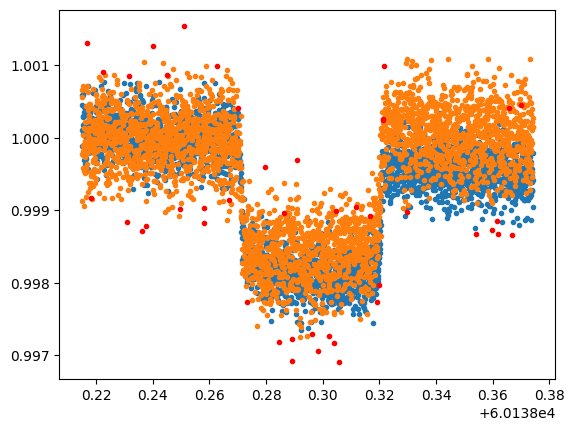

In [62]:
from astropy.stats import sigma_clip
from scipy.signal import savgol_filter

nrs1_white_light = np.sum(spec_nrs1, axis=1)
nrs2_white_light = np.sum(spec_nrs2, axis=1)

nrs1_filt = savgol_filter(nrs1_white_light, window_length=200, polyorder=3)
nrs2_filt = savgol_filter(nrs2_white_light, window_length=200, polyorder=3)
m1 = sigma_clip(nrs1_white_light - nrs1_filt, sigma=3).mask
m2 = sigma_clip(nrs2_white_light - nrs2_filt, sigma=3).mask

nrs1_norm = nrs1_white_light / np.median(nrs1_white_light[:1000])
nrs2_norm = nrs2_white_light / np.median(nrs2_white_light[:1000])

t = time[~m1 & ~m2]
nrs1_norm_clipped = nrs1_norm[~m1 & ~m2]
nrs2_norm_clipped = nrs2_norm[~m1 & ~m2]

data = jnp.array([nrs1_norm_clipped, nrs2_norm_clipped])
plt.plot(t, data.T, '.');
plt.plot(time[m1], nrs1_norm[m1], 'r.')
plt.plot(time[m2], nrs2_norm[m2], 'r.')

In [63]:
term = lambda log_omega, log_sigma: tinygp.kernels.quasisep.SHO(
    omega=jnp.exp(log_omega), sigma=jnp.exp(log_sigma), quality=1/np.sqrt(2)
)
mean = lambda t, f0, m, q1, q2, r2, d, t0, b0: transit_with_trend(t, f0, m, 20.0, q1, q2, r2, d, t0, b0)

oot_length = 100
nbands = len(data)

In [64]:
model = multiband(
    t - t[0],
    len(data),
    term,
    mean,
    constant_params = ['q1', 'q2']
)

print(model.param_names)

['noise:log_omega', 'noise:log_sigma', 'noise:a[0]', 'noise:log_diag[0]', 'noise:log_diag[1]', 'mean:f0[0]', 'mean:f0[1]', 'mean:m[0]', 'mean:m[1]', 'mean:q1', 'mean:q2', 'mean:r2[0]', 'mean:r2[1]', 'mean:d[0]', 'mean:d[1]', 'mean:t0[0]', 'mean:t0[1]', 'mean:b0[0]', 'mean:b0[1]']


param[0]	 noise:log_omega : 5.0000  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[1]	 noise:log_sigma : -10.0000  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[2]	 noise:a[0] : 0.5000  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[3]	 noise:log_diag[0] : -16.5547  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[4]	 noise:log_diag[1] : -15.7205  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[5]	 mean:f0[0] : 1.0001  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[6]	 mean:f0[1] : 0.9999  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[7]	 mean:m[0] : -0.0039  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[8]	 mean:m[1] : 0.0007  <function priors.no_prior.<locals>.<lambda> at 0x2f42d07c0>
param[9]	 mean:q1 : 0.1000  <function priors.uniform.<locals>.<lambda> at 0x303f37f60>
param[10]	 mean:q2 : 0.0100  <function priors.uniform.<locals>.<l

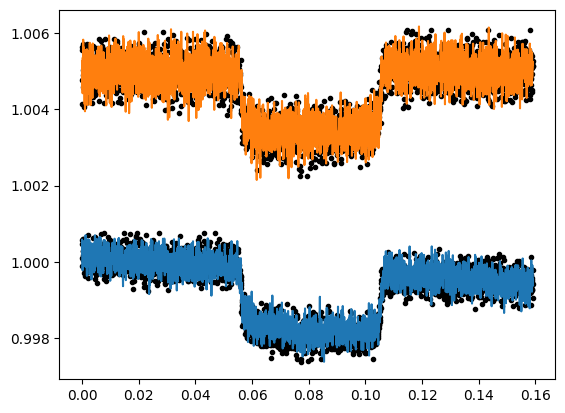

In [72]:
# initial values for parameters
f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.1, 0.01]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
gp_params = [5, -10]
log_var = [np.log(np.var(d[:oot_length])) for d in data]
amps = [0.5] * (nbands - 1)

# construct a jax array of the input parameters
p = jnp.array(gp_params + amps + log_var + f0 + m0 + ld + r2 + dur_t0_b)

# set some priors
log_priors = [priors.no_prior()] * len(p)
log_priors[9] = priors.uniform(0, 1)
log_priors[10] = priors.uniform(0, 1)
log_priors[17] = priors.bounded_normal(0, 1, 0, 0.5)
log_priors[18] = priors.bounded_normal(0, 1, 0, 0.5)

# get the log-probability function 
lp = model.get_logp(data, log_priors=log_priors)

# get a function to sample the model for checking that we have sensible inputs 
sampler = model.get_sampler()

# print out our initial parameters and priors to check that everything makes sense 
[
    print("param[{0}]\t".format(i), pname, ": {:0.4f} ".format(p), pr) 
    for i, (pname, p, pr) in enumerate(zip(model.param_names, p, log_priors))
]

# check that the log-probability is finite and not too small 
print(lp(p))

# sample the model with our initial parameters and plot over the data
# to check that everything looks sensible 
sample = sampler(p)
for i in range(2):
    plt.plot(t - t[0], data[i] + 0.005 * i, 'k.')
    plt.plot(t - t[0], sample[i::2] + 0.005 * i)

In [76]:
# run window adaptation to get initial parameters and inverse mass matrix for the nuts sampler 
%time state, adapt_params = window_adapt(lp, p, 1500)
# sample the model for 500 steps
mcmc_states = run_inference(lp, state.position, 500, adapt_params=adapt_params, progress=True)

CPU times: user 1h 53s, sys: 25min 24s, total: 1h 26min 17s
Wall time: 3h 54min 36s


  0%|          | 0/500 [00:00<?, ?it/s]

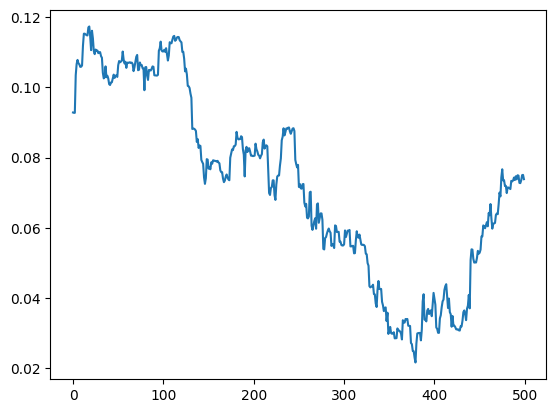

In [74]:
plt.plot(mcmc_states.position[:, 9])

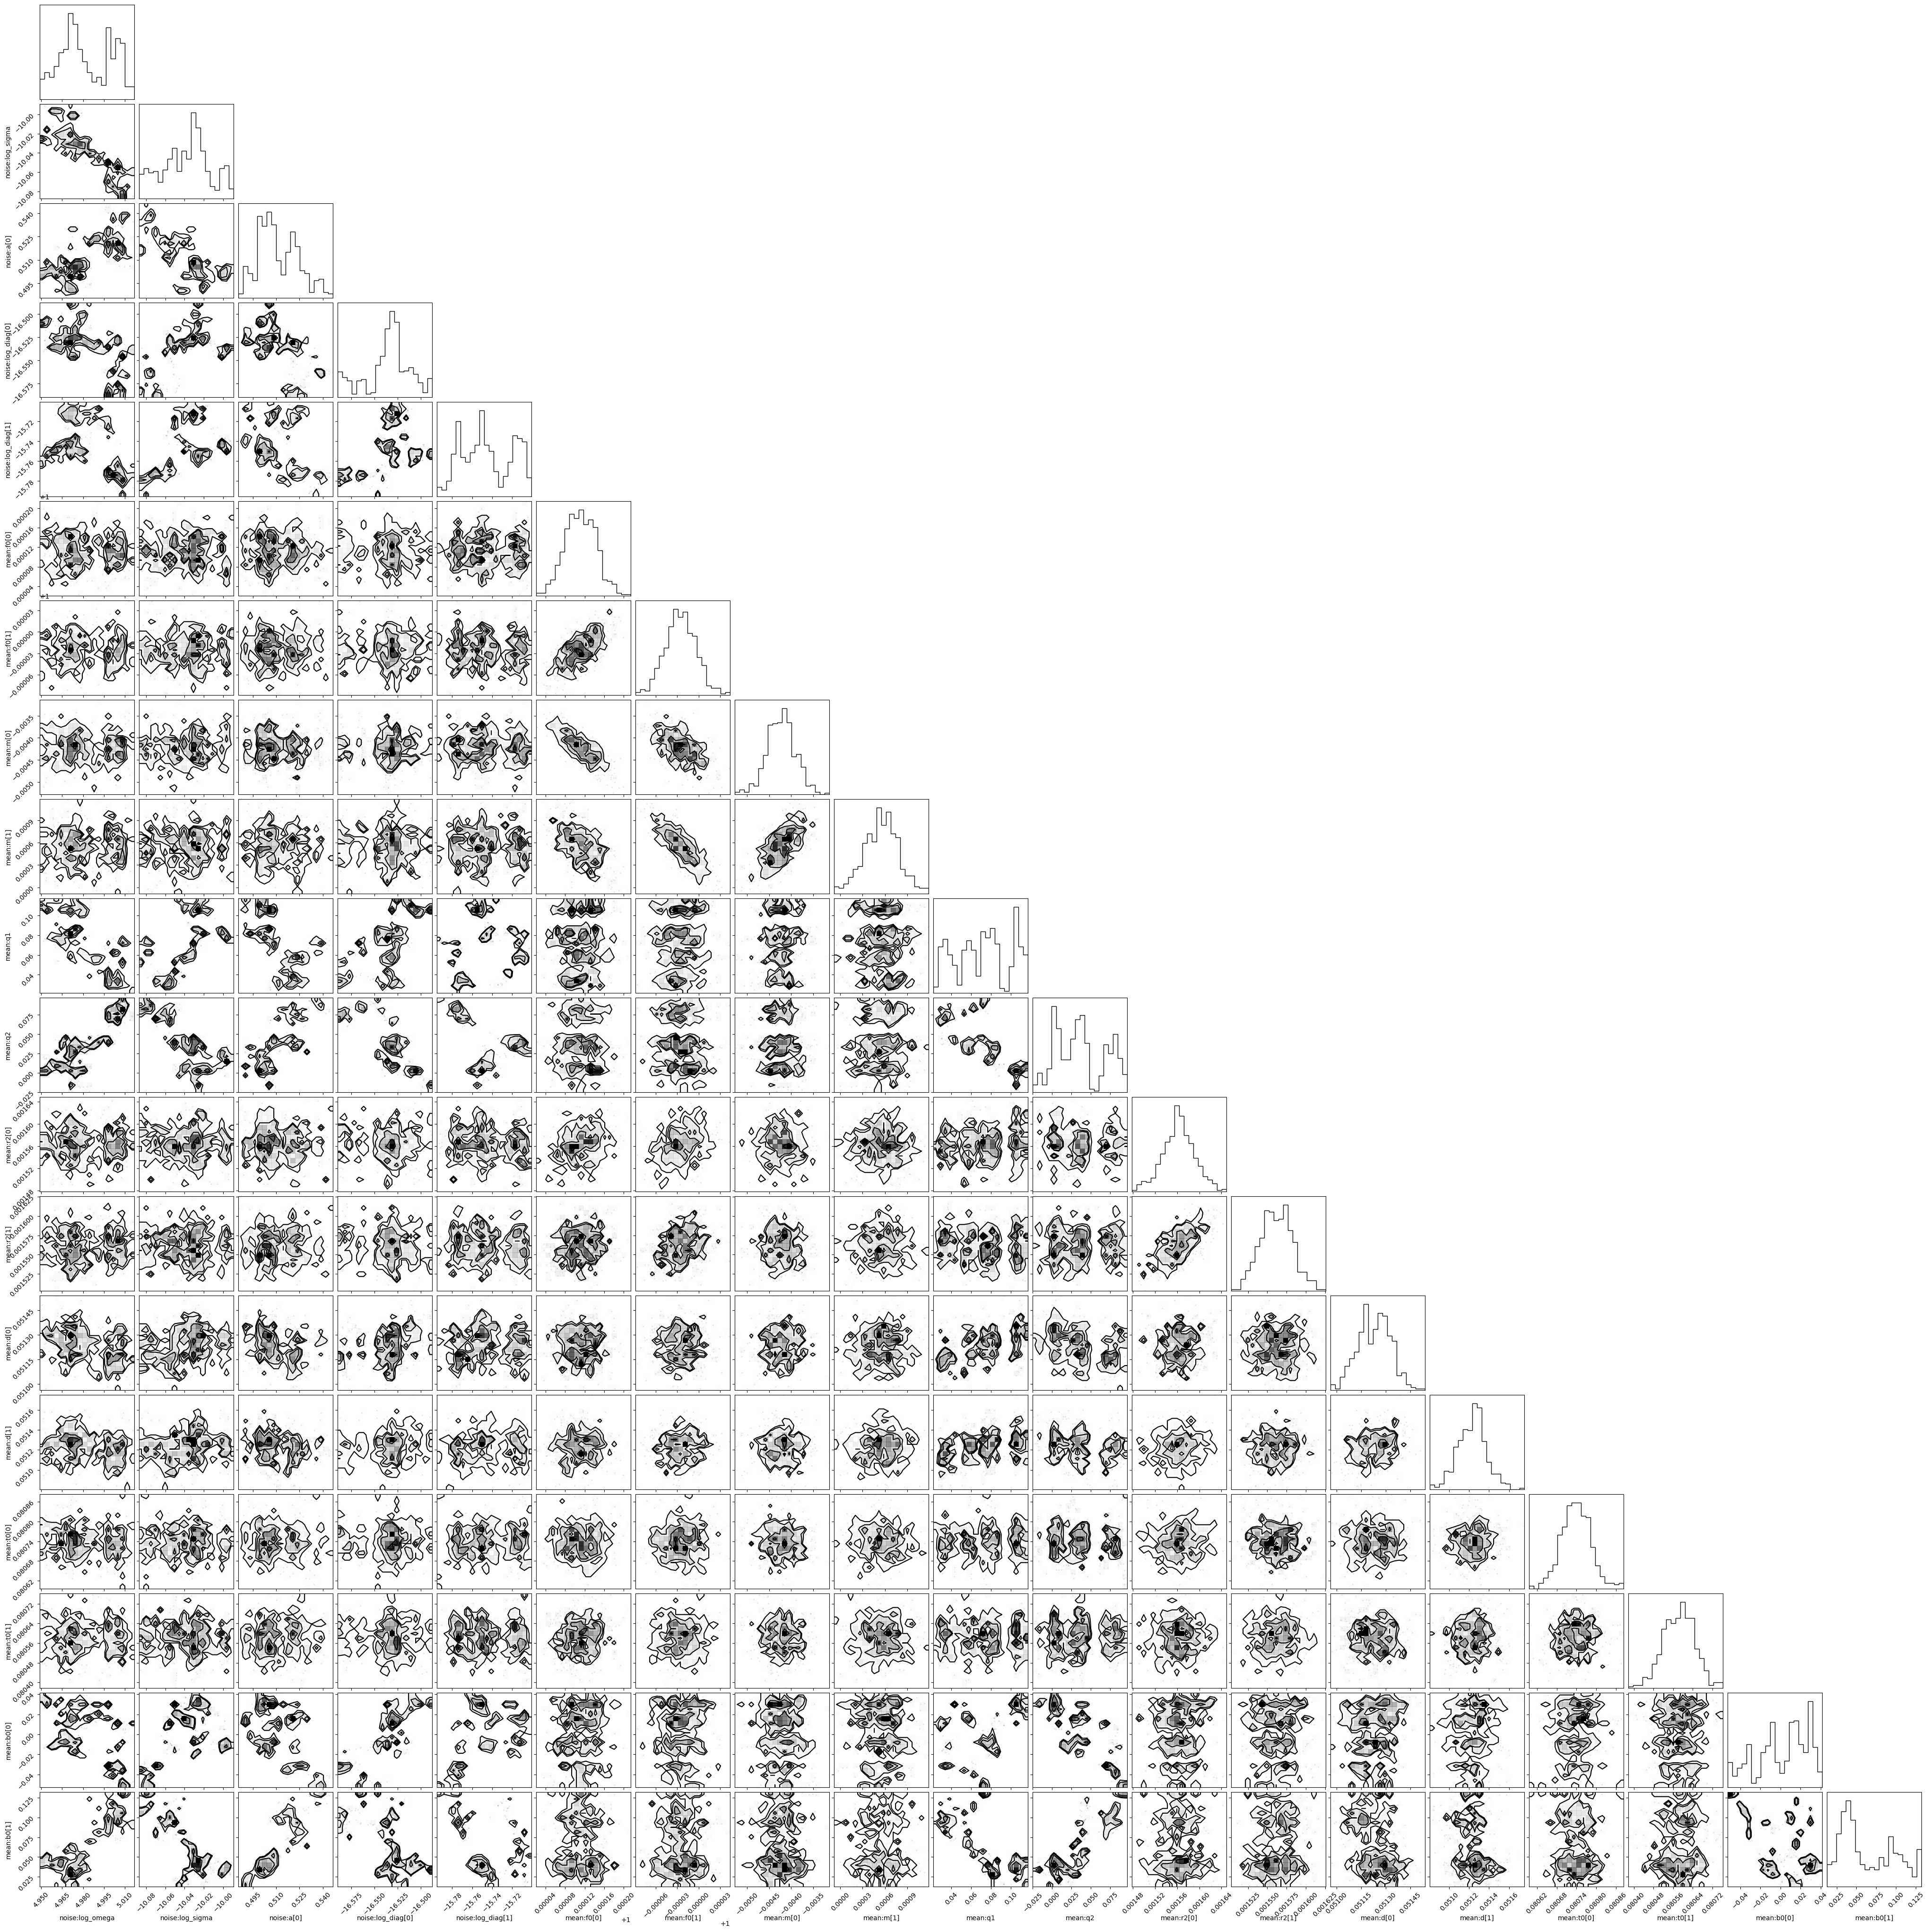

In [75]:
corner.corner(np.array(mcmc_states.position), labels=model.param_names);

In [ ]:
model = multiband_independent(
    t - t[0],
    len(data),
    term,
    mean,
    hold = ['q1', 'q2', 'log_omega']
)

In [ ]:
f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.01, 0.8]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
gp_params = [5, -10]
log_var = [np.log(np.var(d[:oot_length])) for d in data]

p = jnp.array([5] + [-10.0] * 2 + log_var + f0 + m0 + ld + r2 + dur_t0_b)
lp = model.get_logp(data)
[print(pname, ": {0}".format(p)) for pname, p in zip(model.param_names, p)]
print(lp(p))
sample = sampler(p, seed=1)

for i in range(2):
    plt.plot(t, data[i] + 0.005 * i, 'k.')
    plt.plot(t, sample[i::2] + 0.005 * i)

In [ ]:
state, adapt_params = window_adapt(lp, p, 500)
mcmc_states_independent = run_inference(lp, state.position, 5000, adapt_params=adapt_params)

In [ ]:
import corner
corner.corner(np.array(mcmc_states_independent.position), labels=model.param_names);

In [ ]:
import models
import imp
imp.reload(models)

from models import multiband_no_gp

mean = lambda t, f0, m, q1, q2, r2, d, t0, b0: transit_with_trend(t, f0, m, 20.0, q1, q2, r2, d, t0, b0)

model = multiband_no_gp(
    t - t[0],
    len(data),
    mean,
    constant_params = ['q1', 'q2']
)

oot_length = 100
nbands = len(data)

f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.01, 0.8]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
log_var = [np.log(np.var(d[:oot_length])) for d in data]

p = jnp.array(log_var + f0 + m0 + ld + r2 + dur_t0_b)
lp = model.get_logp(data)
[print(pname, ": {0}".format(p)) for pname, p in zip(model.param_names, p)]
print(lp(p))

In [ ]:
state, adapt_params = window_adapt(lp, p, 500)
mcmc_states_no_gp = run_inference(lp, state.position, 5000, adapt_params=adapt_params)

In [ ]:
model.param_names[8:16]

In [ ]:
labels = ['\n\ndepth\n', '\n\nduration\n', '\n\ntransit time\n', '\n\nimpact parameter\n']

fig = plt.figure()
plt.suptitle("Independent GP")
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r', labels=labels);
plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_id_gp.pdf')


fig = plt.figure()
plt.suptitle('Multiband GP')
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r', labels=labels);

plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_multi_gp.pdf')

fig = plt.figure()
plt.suptitle('No GP')
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, 1::2]), 
              fig=fig, color='r', labels=labels);

plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_no_gp.pdf')

In [ ]:
labels = ['\n\ndepth\n', '\n\nduration\n', '\n\ntransit time\n', '\n\nimpact parameter\n']

fig = plt.figure()
plt.suptitle("NRS 1")
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='r');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, ::2]), 
              fig=fig, color='g', labels=labels);
plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/comparison_nrs1.pdf')


fig = plt.figure()
plt.suptitle('NRS 2')
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, 1::2]), 
              fig=fig, color='g', labels=labels);

plt.savefig('/Users/tylergordon/Desktop/comparison_nrs2.pdf')

plt.subplots_adjust(left=0.2,bottom=0.2)

In [ ]:
mean_func = model.mean_builder()

nsamps = 100

plt.figure(figsize=(20, 30))
plt.plot(t, data[0] + 0.005, 'k.', alpha=0.3)
plt.plot(t, data[1], 'k.', alpha=0.3)

inds = np.random.randint(3000, size=nsamps)

samps = [mcmc_states_independent.position[2000:, 5:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='r', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='r', alpha=0.3) for s in samps];

samps = [mcmc_states.position[2000:, 5:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='b', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='b', alpha=0.3) for s in samps];

samps = [mcmc_states_no_gp.position[2000:, 2:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='g', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='g', alpha=0.3) for s in samps];

plt.savefig('/Users/tylergordon/Desktop/lc_withsamps.pdf')